<a href="https://colab.research.google.com/github/sadiet20/HighLight/blob/main/highlight_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set Up Environment

In [ ]:
#@title Default title text

# Setup environment
!apt-get -qq install xxd
!pip install pandas numpy matplotlib
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Upload Data

1. Open the panel on the left side of Colab by clicking on the __>__
1. Select the files tab
1. Drag files from your computer to the tab to upload them into colab.

In [ ]:
tflite_model_name = 'hit_model'  # Will be given .tflite suffix
c_model_name = 'hit_model'       # Will be given .h suffix

# Graph Acceleration Data - not necessary

<ipython-input-3-a77ada219e2d>:17: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "g." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['rms'], 'g.', label='rms', linestyle='solid', marker=',')
<ipython-input-3-a77ada219e2d>:18: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "b." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['piezo'], 'b.', label='piezo', linestyle='solid', marker=',')


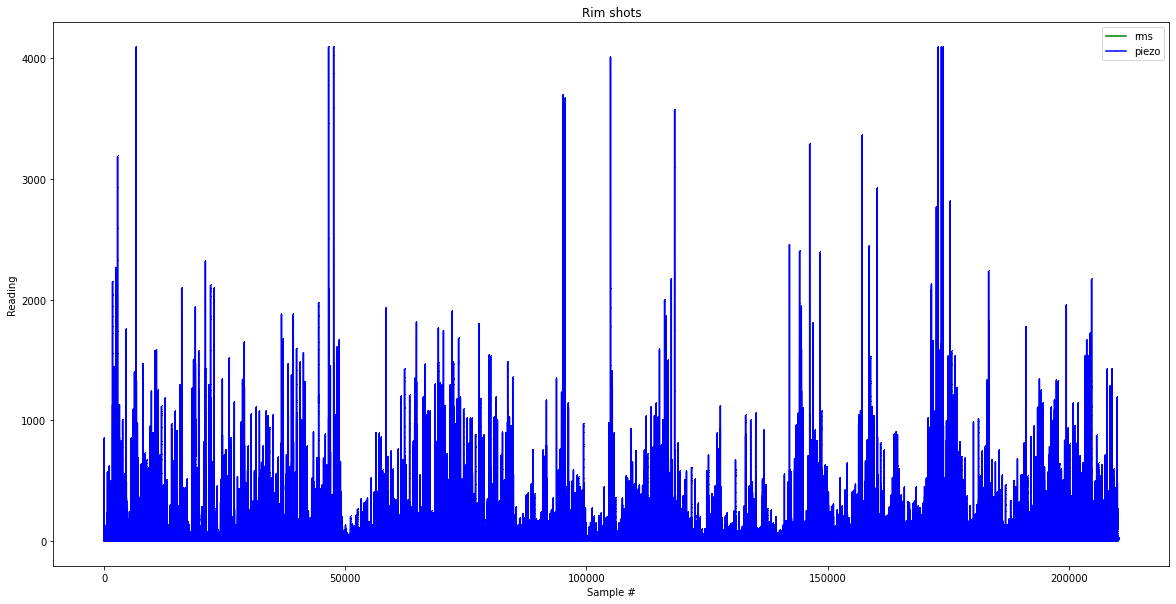

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

filename = "rim_shot.csv"
#filename = "net_shot.csv"

df = pd.read_csv("/content/" + filename)
index = range(1, len(df['rms']) + 1)

#srl added to check sample size
# index = range(1, 1401)
# partial_df = df.iloc[:1400]

plt.rcParams["figure.figsize"] = (20,10)

plt.plot(index, df['rms'], 'g.', label='rms', linestyle='solid', marker=',')
plt.plot(index, df['piezo'], 'b.', label='piezo', linestyle='solid', marker=',')
plt.title("Rim shots")
plt.xlabel("Sample #")
plt.ylabel("Reading")
plt.legend()
plt.show()

# Build and Train Neural Network
1. Parse and Prepare Data


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import time
import math

print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = int(time.time())
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of hit types that data is available for
HIT_TYPES = [
    "net_shot",
    "rim_shot",
]

SAMPLES_PER_HIT = 350

NUM_HIT_TYPES = len(HIT_TYPES)


# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_HIT_TYPES = np.eye(NUM_HIT_TYPES)

inputs = []
outputs = []

# read each csv file and push an input and output
for hit_index in range(NUM_HIT_TYPES):
  hit_type = HIT_TYPES[hit_index]
  print(f"Processing index {hit_index} for hit type '{hit_type}'.")
  
  output = ONE_HOT_ENCODED_HIT_TYPES[hit_index]
  
  df = pd.read_csv("/content/" + hit_type + ".csv", skip_blank_lines=False)
  
  # calculate the number of gesture recordings in the file
  num_recordings = int((df.shape[0]+1) / (SAMPLES_PER_HIT+1)) #added one for each blank line
  
  print(f"\tThere are {num_recordings} recordings of the {hit_type} hit type.")
  
  for i in range(num_recordings):
    tensor = []
    ''' SRL change number of lines in a sample '''
    for j in range(SAMPLES_PER_HIT):
      index = i * (SAMPLES_PER_HIT+1) + j   #added +1 because there is a space between each sample

      #if first line of sample, make sure the previous line was blank
      if(j==0 and i>0 and not math.isnan(df['rms'][index-1])):
        print("\n\nERROR: INCORRECT SPACING\nLine", index, "\n\n\n")

      #make sure each input is a real number
      if(math.isnan(df['rms'][index]) or math.isnan(df['piezo'][index])):
        print("\n\nERROR: NOT A NUMBER\n\n\n")
      '''
      this version errors in the training section
      tensor.append([
          df['rms'][index],
          df['piezo'][index]
      ])
      '''
      ''' SRL change rms vs. piezo vs. both '''
      tensor += [
          df['rms'][index],
          df['piezo'][index],
      ]
      # tensor += [
      #     df['piezo'][index]
      # ]
      # tensor += [
      #     df['rms'][index]
      # ]
      
    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

#print(inputs)

print("inputs type:", inputs.dtype)
print("outputs type:", outputs.dtype)

#srl don't think I need this bc they're already floats (but they're 64 not 32)
#inputs = inputs.astype(np.float32)
#outputs = outputs.astype(np.float32)

print("Data set parsing and preparation complete.")

TensorFlow version = 2.11.0

Processing index 0 for hit type 'net_shot'.
	There are 540 recordings of the net_shot hit type.
Processing index 1 for hit type 'rim_shot'.
	There are 601 recordings of the rim_shot hit type.
inputs type: float64
outputs type: float64
Data set parsing and preparation complete.


2. Randomize and Split Pairs for Training

In [ ]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])


print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


3. Build and Train Model

In [ ]:
''' build the model and train it '''
model = tf.keras.Sequential()   # sequential means it goes from input layer -> hidden layers -> output layers

# Add layers
model.add(tf.keras.layers.Dense(256, input_dim=inputs_train[0].shape[0], activation='relu', name="input")) # relu is used for performance
model.add(tf.keras.layers.Dense(128, activation='relu', name="layer1"))
model.add(tf.keras.layers.Dense(64, activation='relu', name="layer2"))
model.add(tf.keras.layers.Dense(64, activation='relu', name="layer3"))
model.add(tf.keras.layers.Dense(32, activation='relu', name="layer4"))
model.add(tf.keras.layers.Dense(16, activation='relu', name="layer5"))
model.add(tf.keras.layers.Dense(8, activation='relu', name="layer6"))
model.add(tf.keras.layers.Dense(NUM_HIT_TYPES, activation='softmax', name="output")) # softmax assigns probabibility to prediction of each class

# Set up loss function, optimier and performance evaluation metrics
#opt=tf.keras.optimizers.SGD(learning_rate=0.0001, name="SGD")
opt=tf.keras.optimizers.Adam(learning_rate=0.0001)      #Adam is good for lots of parameters
#opt=tf.keras.optimizers.RMSprop(learning_rate=0.00001, momentum=0.99)
model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])

# Train the model
history = model.fit(inputs_train, outputs_train, 
                    epochs=600,                     #number of times model processes the entire dataset
                    batch_size=16,                  #number of examples to evaluate before updating model weights/biases, best to be multiple of 2
                    validation_data=(inputs_validate, outputs_validate))    #training evaluation

Epoch 1/600
43/43 [==============================] - 4s 18ms/step - loss: 0.4895 - accuracy: 0.5088 - val_loss: 0.4436 - val_accuracy: 0.5459
Epoch 2/600
43/43 [==============================] - 0s 10ms/step - loss: 0.3928 - accuracy: 0.5599 - val_loss: 0.2445 - val_accuracy: 0.7118
Epoch 3/600
43/43 [==============================] - 0s 9ms/step - loss: 0.2267 - accuracy: 0.7412 - val_loss: 0.2280 - val_accuracy: 0.7380
Epoch 4/600
43/43 [==============================] - 0s 9ms/step - loss: 0.1790 - accuracy: 0.7982 - val_loss: 0.2037 - val_accuracy: 0.7555
Epoch 5/600
43/43 [==============================] - 0s 7ms/step - loss: 0.1606 - accuracy: 0.8129 - val_loss: 0.2253 - val_accuracy: 0.7598
Epoch 6/600
43/43 [==============================] - 0s 4ms/step - loss: 0.1427 - accuracy: 0.8363 - val_loss: 0.2064 - val_accuracy: 0.7598
Epoch 7/600
43/43 [==============================] - 0s 4ms/step - loss: 0.1194 - accuracy: 0.8684 - val_loss: 0.2269 - val_accuracy: 0.7380
Epoch 8/600

In [ ]:
# View model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Dense)               (None, 256)               179456    
                                                                 
 layer1 (Dense)              (None, 128)               32896     
                                                                 
 layer2 (Dense)              (None, 64)                8256      
                                                                 
 layer3 (Dense)              (None, 64)                4160      
                                                                 
 layer4 (Dense)              (None, 32)                2080      
                                                                 
 layer5 (Dense)              (None, 16)                528       
                                                                 
 layer6 (Dense)              (None, 8)                

# Verify

Graph Loss

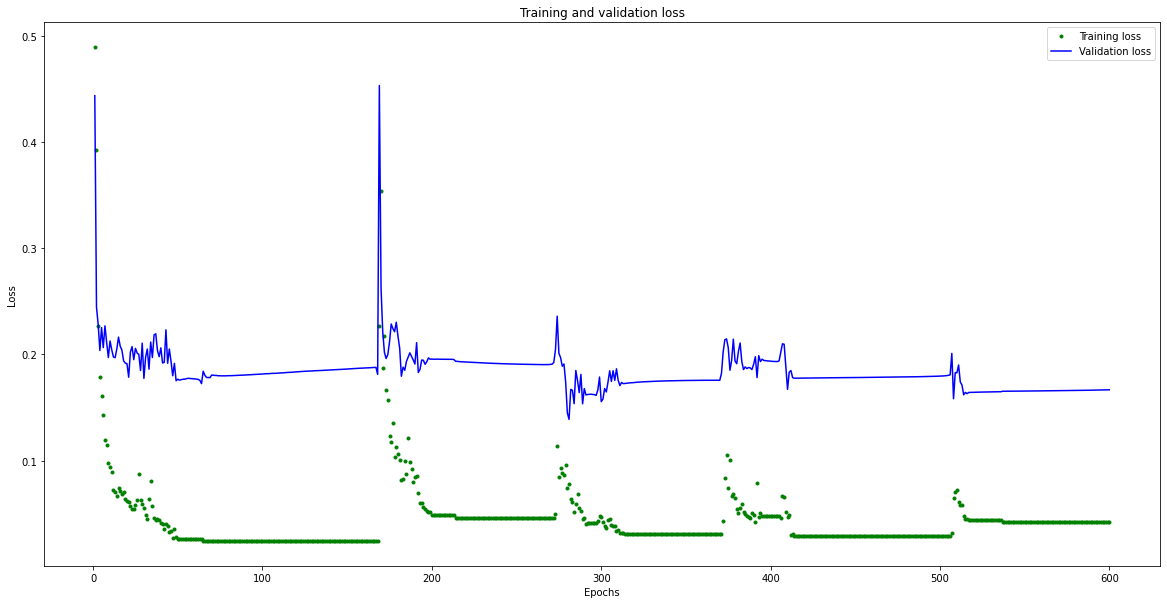

[20.0, 10.0]


In [ ]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

Graph Loss Skip Part of Beginning

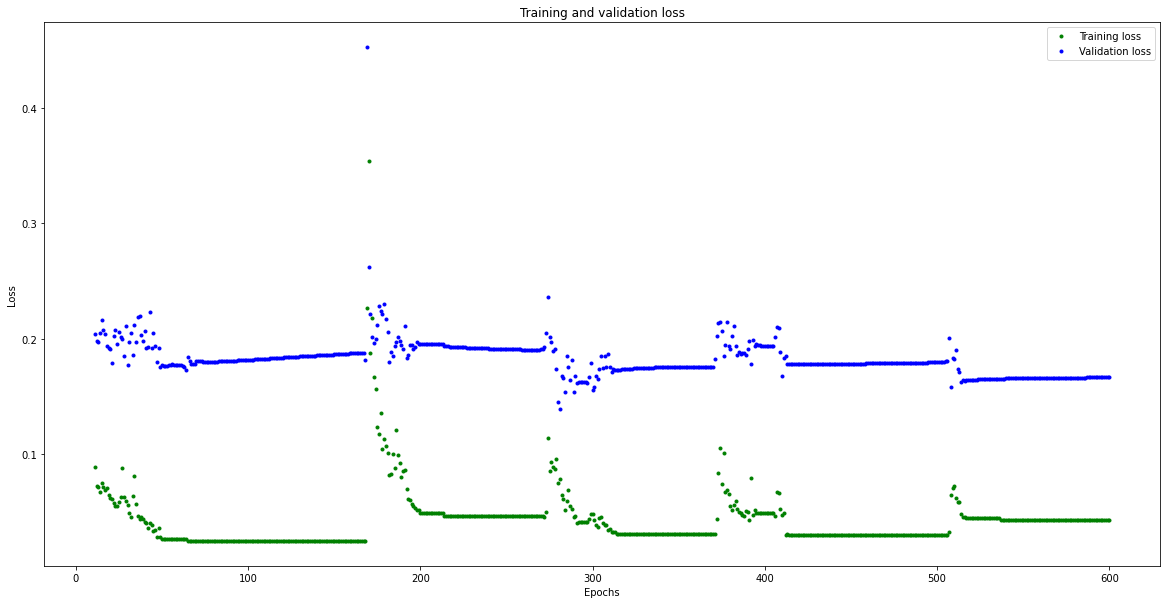

In [ ]:
# graph the loss again skipping a bit of the start
SKIP = 10
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Graph MAE

In [ ]:
# graph of mean absolute error
mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

KeyError: ignored

Graph Accuracy

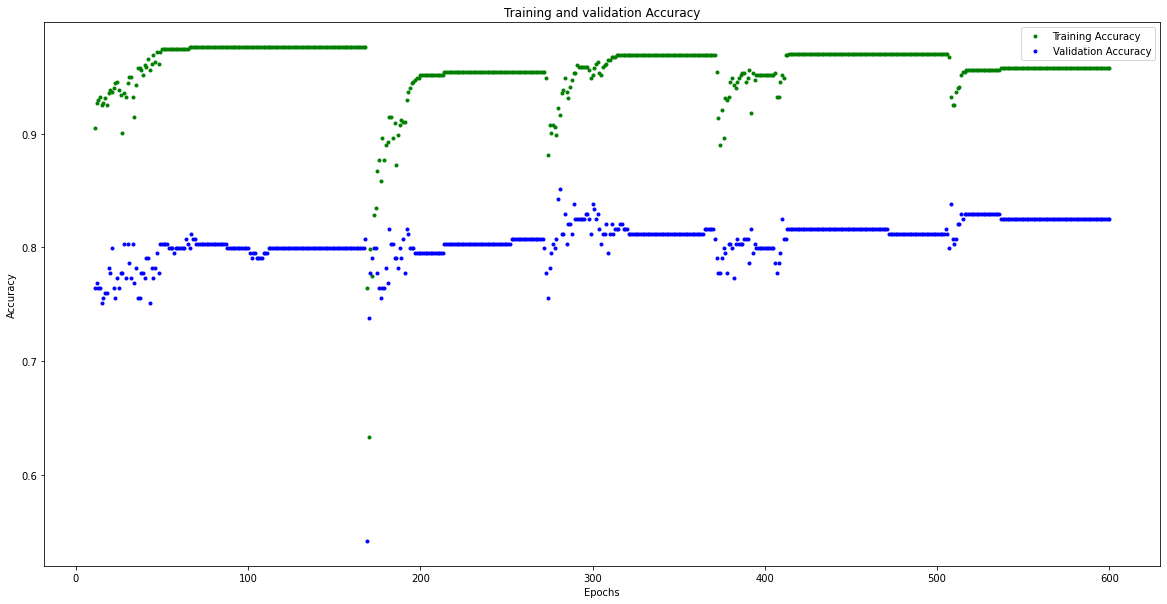

In [ ]:
# graph of accuracy
mae = history.history['accuracy']
val_mae = history.history['val_accuracy']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training Accuracy')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Run with Test Data

8/8 [==============================] - 0s 3ms/step
predictions =
 [[0.    1.   ]
 [1.    0.   ]
 [0.    1.   ]
 [0.008 0.992]
 [1.    0.   ]
 [0.    1.   ]
 [1.    0.   ]
 [1.    0.   ]
 [0.    1.   ]
 [0.698 0.302]
 [1.    0.   ]
 [0.    1.   ]
 [1.    0.   ]
 [1.    0.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.042 0.958]
 [0.    1.   ]
 [0.    1.   ]
 [0.252 0.748]
 [0.    1.   ]
 [0.    1.   ]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [1.    0.   ]
 [0.226 0.774]
 [0.382 0.618]
 [1.    0.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.092 0.908]
 [1.    0.   ]
 [0.    1.   ]
 [1.    0.   ]
 [0.    1.   ]
 [1.    0.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [1.    0.   ]
 [0.988 0.012]
 [0.    1.   ]
 [1.    0.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [1.    0.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [0.992 0.008]
 [0.    1.   ]
 [0.    1.   ]
 [0.    1.   ]
 [1.    0.   ]
 [1.    0.   ]
 [1.

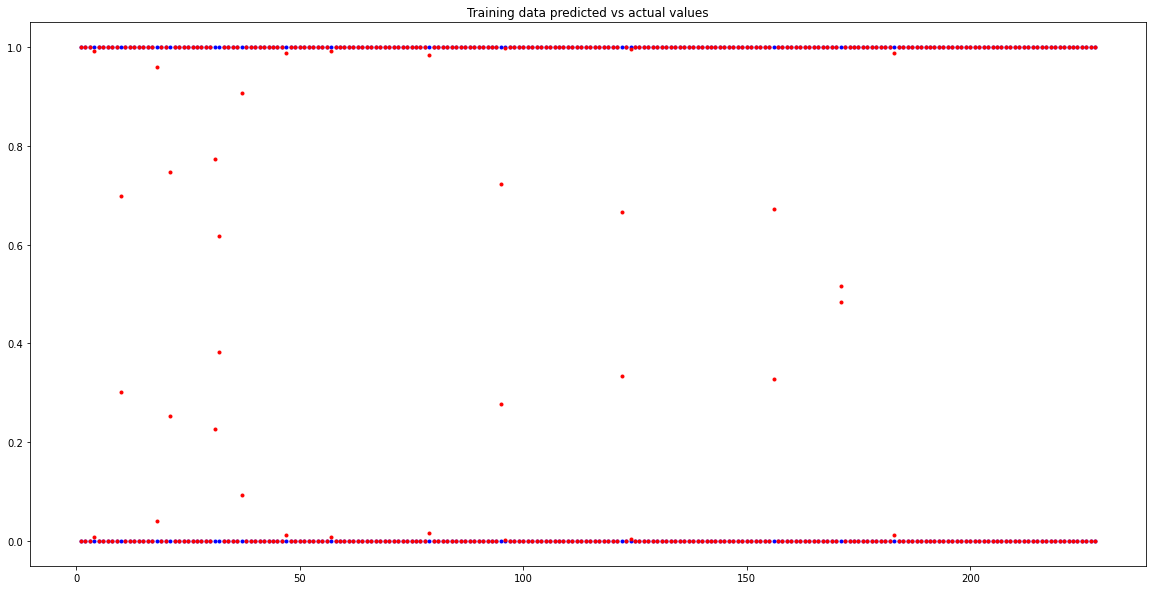

In [ ]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)

corr_rim = 0
corr_net = 0
incr_net = 0
incr_rim = 0

for i in range(len(predictions)):
  #actually was a net shot
  if outputs_test[i][0] == 1:
    #predicted net shot
    if predictions[i][0] > predictions[i][1]:
      corr_net += 1
    else:
      print(f"Acutal: net Predicted: {np.round(predictions[i][0], decimals=3)} net")
      incr_net += 1
  #actually was a rim shot
  elif outputs_test[i][1] == 1:
    if predictions[i][0] < predictions[i][1]:
      corr_rim += 1
    else:
      print(f"Acutal: rim Predicted: {np.round(predictions[i][1], decimals=3)} rim")
      incr_rim += 1

print("Correct Net: ", corr_net)
print("Correct Rim: ", corr_rim)
print("Incorrect Net: ", incr_net)
print("Incorrect Rim: ", incr_rim)
print(f"Correct Net: {corr_net} / {(corr_net + incr_net)} = {100*corr_net/(corr_net + incr_net)} %")
print(f"Correct Rim: {corr_rim} / {(corr_rim + incr_rim)} = {100*corr_rim/(corr_rim + incr_rim)} %")


# Plot the predictions along with to the test data
index = range(1, len(inputs_test) + 1)
plt.clf()
plt.title('Training data predicted vs actual values')
plt.plot(index, outputs_test, 'b.', label='Actual')
plt.plot(index, predictions, 'r.', label='Predicted')
plt.show()

# Convert to tflite

In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)
  

Model is 914248 bytes


#Convert to Arduino header file #

In [ ]:
!echo "const unsigned char model[] = {" > /content/model.h
!cat gesture_model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 5,637,898 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.
